# Neural event detection: 
### A simple example

Author: Ali Zaidi

Date 20.08.2019

In [1]:
from __future__ import print_function, absolute_import

In [2]:
from scipy.signal import stft, istft, find_peaks
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [5]:
# Load the data
fname = "./data/Time_Series_N2_long.mat"
data = sio.loadmat(fname)
Vp=data['Vp']

In [6]:
# Separate the data into train and test set

split =3*Vp.shape[1]//4

Vp_train = Vp[:,:split]
Vp_test = Vp[:,split:]

In [7]:
print(Vp_train.shape, Vp_test.shape)

(1, 9000000) (1, 3000000)


In [36]:
# Obtain STFT of training data

nperseg=1024
noverlap=256

f, t, data_stft = stft(Vp_train, fs=1000, nperseg=nperseg, noverlap=noverlap, axis=1)
data_stft = np.abs(np.squeeze(data_stft)) # Required for normalization
data_stft = data_stft[:200,:]
f = f[:200]

In [57]:
# Normalize STFT

dsm = np.mean(data_stft, axis=1)
dsm_r = np.repeat(dsm[:, np.newaxis], data_stft.shape[1], axis=1)

dsd = np.std(data_stft, axis=1)
dsd_r = np.repeat(dsd[:, np.newaxis], data_stft.shape[1], axis=1)

data_stft_norm = data_stft / dsm_r

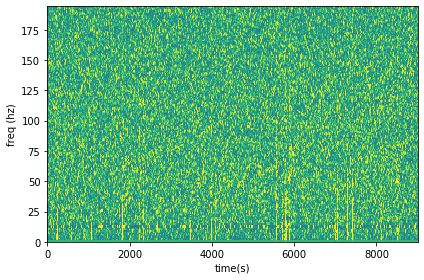

In [58]:
# Visualize
plt.figure()
plt.pcolormesh(t, f, data_stft_norm)
plt.clim([-1, 2])
plt.xlabel('time(s)')
plt.ylabel('freq (hz)')
plt.tight_layout()

### Manifold approximation based dimensionality reduction

In [59]:
# Embed the STFT frames in a lower dimensions. This helps visualization of clusters
from umap import UMAP
manifold = UMAP(min_dist=0.001)
embedding = manifold.fit_transform(data_stft_norm.T)

## Using DBSCAN for clustering

### Applying it to the manifold

In [60]:
from sklearn.cluster import DBSCAN
clustering=DBSCAN().fit(embedding)
l=clustering.labels_
# Obtain the label counts (Assumption: background activity is much more common than our events of interest)
values, counts = np.unique(l, return_counts=True)
print(dict(zip(values, counts)))

{-1: 2, 0: 742, 1: 8720, 2: 2256}


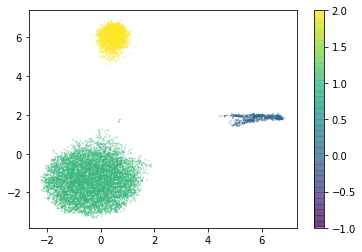

In [61]:
# Visualize clusters
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], marker='.', alpha=0.5, c=l, s=1)
plt.colorbar()

### Applying DBSCAN to the original STFT data

In [62]:
from sklearn.cluster import DBSCAN
clustering=DBSCAN().fit(data_stft_norm.T)
l1=clustering.labels_
# Obtain the label counts (Assumption: background activity is much more common than our events of interest)
values, counts = np.unique(l1, return_counts=True)
print(dict(zip(values, counts)))

{-1: 11720}


### This shows that the entire dataset is considered noise (label value of -1 corresponds to noise in DBSCAN)

## Attempt the same with a PCA based decomposition

In [77]:
from sklearn.decomposition import PCA
components = PCA(n_components=2).fit_transform(data_stft_norm.T)

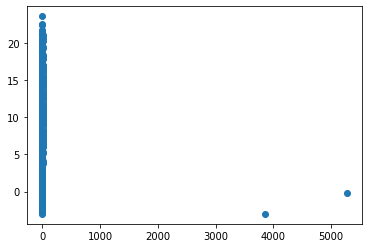

In [78]:
plt.scatter(components[:,0], components[:,1])